In [1]:
import h5py
import numpy as np
import os

file_path = '/Users/franciscodowney/Desktop/UCLA/Courses/Winter Quarter 2025/228/Project/Sample Data/LUAD/TCGA-34-2605-01Z-00-DX1.h5'
file_path2 = '/Users/franciscodowney/Desktop/UCLA/Courses/Winter Quarter 2025/228/Project/Sample Data/LUSC/TCGA-60-2695-01Z-00-DX1.h5'



if os.path.exists(file_path):
    with h5py.File(file_path, "r") as h5_file:
        
        datasets = list(h5_file.keys())
        print(f"Datasets inside the file: {datasets}")

        # Extract & Check the Features Dataset
        if "features" in datasets:
            features = h5_file["features"][:]  # Load all feature data
            print(f"\nShape of 'features': {features.shape}")  # Expected (num_tiles, 1024)
            print(f"Sample Features (first 5 rows):\n{features[:5]}")  # Print first 5 feature vectors

       
        if "coords" in datasets:
            coords = h5_file["coords"][:]
            print(f"\nShape of 'coords': {coords.shape}")  # Expected (num_tiles, 2)
         

Datasets inside the file: ['coords', 'features']

Shape of 'features': (11118, 1024)
Sample Features (first 5 rows):
[[ 1.4743148  -0.66672665 -1.974797   ... -0.3268076   2.287257
   0.6425188 ]
 [ 0.49487564 -0.9996067  -1.453786   ... -0.70884335  0.656675
   0.96511996]
 [-1.0826533   0.16203742 -2.3214774  ...  0.04512507 -0.06246603
   0.34042126]
 [-2.598149   -1.0536268  -1.3663765  ...  0.65569067 -0.8721822
  -1.6494672 ]
 [-0.732723   -1.2198707  -2.5369122  ...  1.1126738  -0.04896246
  -0.5632508 ]]

Shape of 'coords': (11118, 2)


In [2]:
import h5py
import numpy as np
import os

# Define Paths to LUAD and LUSC Folders
base_path = '/Users/franciscodowney/Desktop/UCLA/Courses/Winter Quarter 2025/228/Project/Sample Data/TCGA'
luad_path = os.path.join(base_path, "LUAD")  # Folder containing LUAD .h5 files
lusc_path = os.path.join(base_path, "LUSC")  # Folder containing LUSC .h5 files


X = []  # Feature vectors
y = []  # Labels (0 = LUAD, 1 = LUSC)

# 📌 Step 4: Function to Load Features from HDF5 Files
def load_features_from_folder(folder_path, label):
    """Loads features from all .h5 files in a folder and assigns a label."""
    for subdir, _, files in os.walk(folder_path):  # Walk through subdirectories
        for file in files:
            if file.endswith(".h5"):  # Ensure it's an HDF5 file
                file_path = os.path.join(subdir, file)
                with h5py.File(file_path, "r") as h5_file:
                    if "features" in h5_file:
                        features = h5_file["features"][:]  # Extract features
                        X.append(features)  # Append feature matrix
                        y.append(np.full(features.shape[0], label))  # Assign labels


load_features_from_folder(luad_path, label=0)  # LUAD -> 0
load_features_from_folder(lusc_path, label=1)  # LUSC -> 1


X = np.vstack(X)  # Stack all feature matrices into a single dataset
y = np.concatenate(y)  # Flatten labels into a single array

# 📌 Step 7: Print Dataset Information
print(f"Data Loaded Successfully!")
print(f"Total Samples: {X.shape[0]}")
print(f"Feature Dimension: {X.shape[1]}")
print(f"Labels Distribution: {np.bincount(y)}")  # Count LUAD (0) and LUSC (1)

Data Loaded Successfully!
Total Samples: 71798
Feature Dimension: 1024
Labels Distribution: [34126 37672]


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize feature values


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Example: 2 hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train, y_train)


y_pred = mlp.predict(X_test)
y_pred_prob = mlp.predict_proba(X_test)[:, 1]  # Get probability scores


accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_prob)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")


print(f" MLP Model Trained Successfully!")
print(f" Accuracy: {accuracy:.4f}")
print(f" AUROC Score: {auroc:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")

 MLP Model Trained Successfully!
 Accuracy: 0.9998
 AUROC Score: 1.0000
 Precision: 1.0000
 Recall: 0.9996
 F1 Score: 0.9998


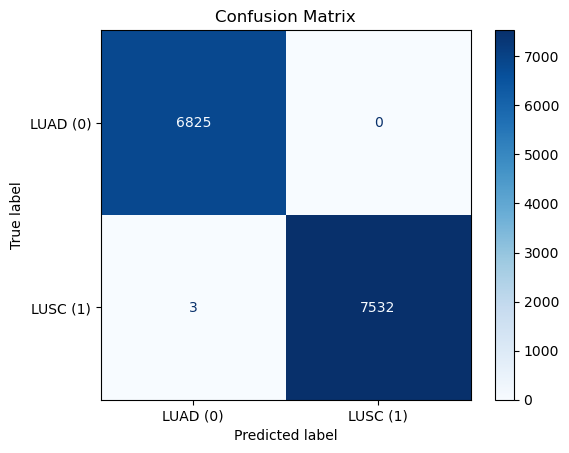

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LUAD (0)", "LUSC (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


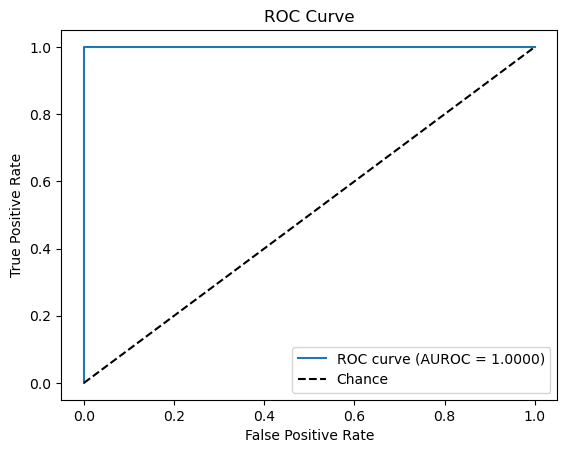

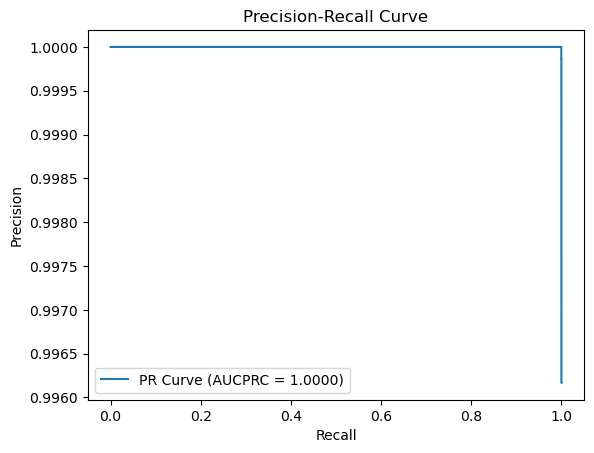

 MLP Model Trained Successfully!
 Accuracy: 0.9998
 AUROC Score: 1.0000
 AUCPRC Score: 1.0000
 Precision: 1.0000
 Recall: 0.9996
 F1 Score: 0.9998


In [5]:
from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    average_precision_score, 
    auc
)
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUROC = {auroc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)
aucprc = auc(recall_vals, precision_vals)
plt.figure()
plt.plot(recall_vals, precision_vals, label=f"PR Curve (AUCPRC = {aucprc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Updated print block with AUCPRC
print(f" MLP Model Trained Successfully!")
print(f" Accuracy: {accuracy:.4f}")
print(f" AUROC Score: {auroc:.4f}")
print(f" AUCPRC Score: {aucprc:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
